# Global settings
Run this block first! All remaining blocks can be run in any order

In [1]:
import Drone
from configurations import defaultConfig 
import numpy as np
from plottingFunctions import open_loop_plots, plot_rrt_lines_flipped
import importlib
import ConvexMotionPlanning
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.axes import Axes
from RRTAR import RRTAR
import copy
import math
import random

## PLOT SETUP

# \tiny	5 pt
# \scriptsize	7 pt
# \footnotesize	8 pt
# \small	9 pt
# \normalsize	10 pt
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math
plt.rcParams['lines.linewidth'] = 1

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels

# Define colors of obstacle map
cmap = mpl.colors.ListedColormap([(1, 1, 1, 0), 'black'])

# create a normalize object the describes the limits of each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

---
# Figure 4
MPP trajectory creation process

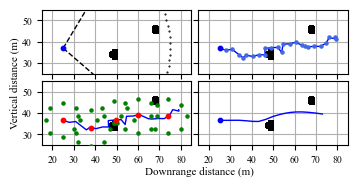

In [9]:
# set random seeds
np.random.seed(42)
random.seed(42)

config = defaultConfig()
config.numObstacles = 12
drone = Drone.Drone(config, config)

thrustCommand = 4.3
fpaCommand = 0/180*np.pi
dynRef = drone.coherentCommand(thrustCommand,fpaCommand)
elivatorRef = drone.elevatorFromAlpha(dynRef[1]-dynRef[3])
stateRef = np.hstack(([0,50], dynRef))
action = (thrustCommand, elivatorRef, dynRef)
drone.reset(stateRef)

observation, grid, reward, terminated = drone.step(action)

fig, axs = plt.subplots(2, 2, figsize=(3.4,1.70),sharex=True,sharey=True,layout="compressed");


## PART I
ax = axs[0,0]
x = drone.ogOrigin[0]
z = drone.ogOrigin[1]
theta = drone.plant.state[3]
beam = drone.lidar_range
angle = drone.lidar_angle
res = drone.lidar_res
a = np.linspace(-angle/2,angle/2,int(res/3))
xs = x+beam*np.cos(theta+a)
zs = z+beam*np.sin(theta+a)
ax.plot([x,x+beam*np.cos(theta+angle/2)],[z,z+beam*np.sin(theta+angle/2)],'k--',zorder=3)
ax.plot([x,x+beam*np.cos(theta-angle/2)],[z,z+beam*np.sin(theta-angle/2)],'k--',zorder=3)
ax.plot(xs,zs,'k.',markersize=1,zorder=3)
ax.scatter(25, 37, color='blue', s=10,zorder=3)

## PART II
ax = axs[0,1]
midpoint = drone.ogOrigin[1]
offset = 10
lookAhead = 54
orignX = drone.ogOrigin[0]
xstart = np.array([orignX, offset]) 
xgoal = [[orignX+lookAhead, offset], [orignX+lookAhead, offset/4],  [orignX+lookAhead, offset/4*2],  [orignX+lookAhead, offset*6/4]]
n = 10
r_rewire = 5
searchGrid = grid[midpoint-offset:midpoint+offset, 0:85].T.astype(int)
vectorsSave = []
rrt = RRTAR()

while (len(vectorsSave) < 1):
    vectors = rrt.runRRT(xstart[0], xstart[1], 100, 3, 4, searchGrid, xgoal)
    for i in range(1, len(vectors)):
        vectorsSave.append(vectors[i])
#tree_plot_2d_vectors(vectors[0], grid[midpoint-offset:midpoint+offset, 0:85].T.astype(int))
for i in range(0, 1):
    vectors = vectorsSave[i]
    for i in range(len(vectors)):
        x = vectors[i][0]
        y = vectors[i][1]+27

        if i > 0:
            target_x = vectors[i-1][0]
            target_y = vectors[i-1][1]+27

            ax.plot([x, target_x], [y, target_y], 'b-', zorder=2)
        ax.scatter(x, y, color='royalblue', s=5, zorder=3)

og=grid[0:midpoint+offset, 0:85].T.astype(int)
ax.scatter(25, 37, color='blue', s=10,zorder=3)


## Part III
ax = axs[1,0]
tEnd = 450
path_pts = np.zeros((len(vectorsSave[0]) - 1, 2, 2))
for i in range(len(vectorsSave[0]) - 1):
    path_pts[i] = np.array([[vectorsSave[0][i][1], vectorsSave[0][i][0]],
                          [vectorsSave[0][i+1][1], vectorsSave[0][i+1][0]]])

numDirections = 8
directs = ConvexMotionPlanning.generateDirections(numDirections)
#ax.scatter(drone.objects[0,:],drone.objects[1,:], color = "red" )
referencePointsPlot, referenceVelsPlot= ConvexMotionPlanning.calculateReferencePoints(tEnd+1, path_pts)

xRefsToPlot = list(zip(*referencePointsPlot))[0]
yRefsToPlot = list(zip(*referencePointsPlot))[1]
indexes = range(len(xRefsToPlot))
indexes = indexes[0::100]

ax.plot(yRefsToPlot, np.array(xRefsToPlot)+26.5, color = 'blue',zorder=3)
for i in indexes:
    cords = ConvexMotionPlanning.searchFromCord([xRefsToPlot[i], yRefsToPlot[i]], directs, searchGrid.T, limit = 8)
    ax.scatter(cords[:, 1], cords[:, 0]+26.5, color = 'green', s=5, zorder=3)
    ax.scatter(yRefsToPlot[i], xRefsToPlot[i]+26.5, color = 'red', s=10, zorder=3)
#ax.scatter(25, 37, color='blue', s=10)


##  PART IV
ax = axs[1,1]
thrustCommandVal = 4.3
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))

iterations = 2000
iter = 0
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
refCommand = np.zeros((iterations, 4))
timeMulti = 25
Acts, Bcts = drone.calculateCTSABMatrix(refStates, controlRef)
Aopt = np.eye(Acts.shape[0]+2)
#A = Aopt + env.calculateANumerical(stateRefFull, controlRef, env.rhoNom, step=10**-5)*env.dt
Aopt[0, 2] = drone.dt*timeMulti
Aopt[1, 5] = refStates[0]*drone.dt*timeMulti
Aopt[2:,2:] = Aopt[2:,2:]+Acts*drone.dt*timeMulti
Bopt = np.zeros([6,2])
Bopt[2:,0:1] = Bcts*drone.dt*timeMulti
alphaEst = refStates[1] - refStates[3]
Bopt[2, 1] = 1/drone.m*np.cos(alphaEst)*drone.dt*timeMulti
Bopt[5, 1] = 1/drone.m*np.sin(alphaEst)/refStates[0]*drone.dt*timeMulti
xstart = np.concatenate(([0.,0.], np.array(drone.stateEstimate) - np.array(refStates) + np.array([0, 0.01, 0, 0])))
xgoal = np.concatenate(([0.,50 - drone.plant.state[1]], [0.,0.,0.,0.]))

referencePoints, referenceVels = ConvexMotionPlanning.calculateReferencePoints(math.floor(tEnd/timeMulti)+1, path_pts)
referencePointsDyn, referenceVelsDyn = ConvexMotionPlanning.calculateReferencePoints(math.floor(tEnd/timeMulti)+1, path_pts)

for i in range(len(referencePointsDyn)):
    referencePointsDyn[i][0] = referencePointsDyn[i][0]-refStates[0]*np.sin(refStates[3])*i*drone.dt*timeMulti-offset
    referencePointsDyn[i][1] = referencePointsDyn[i][1]-refStates[0]*np.cos(refStates[3])*i*drone.dt*timeMulti-orignX

xsol, usol, cost, infeasbility = ConvexMotionPlanning.localTrajOpt(Aopt, Bopt, math.floor(tEnd/timeMulti), grid[midpoint-offset:, 0:80], referencePoints, referencePointsDyn, xstart, xgoal)

for i in range(np.min((tEnd-timeMulti-1, iterations-iter))):
    iDrop = math.floor(i/timeMulti)
    iNext = iDrop+1
    ifrac1 = (timeMulti - i%timeMulti)/timeMulti
    ifrac2 = (i%timeMulti)/timeMulti
    thrustCommand[iter+i] = ifrac1*usol[iDrop][1] + ifrac2*usol[iNext][1]  + thrustCommandVal 
    elivCommand[iter + i] = ifrac1*usol[iDrop][0] + ifrac2*usol[iNext][0] + elivCommandRef
    xCommand[iter+i] = ifrac1*xsol[iDrop][0] + ifrac2*xsol[iNext][0] +refStates[0]*np.cos(0)*i*drone.dt+drone.plant.state[0]
    yCommand[iter+i] = ifrac1*xsol[iDrop][1] + ifrac2*xsol[iNext][1] + refStates[0]*np.sin(0)*i*drone.dt+drone.plant.state[1]
    refCommand[iter+i, :] = ifrac1*xsol[iDrop][2:6].T + ifrac2*xsol[iNext][2:6].T + np.array(refStates)

ax.scatter(25, 36.5, color='blue', s=10, zorder=3)
ax.plot(xCommand[0:tEnd-timeMulti-1]+25, yCommand[0:tEnd-timeMulti-1]-13.5, color = 'blue',zorder=3)

# SET AXIS LIMITS AND INSERT LABELS
for row in axs:
    for ax in row:
        ax.imshow(grid, interpolation=None, cmap=cmap, norm=norm, zorder=2)
        ax.invert_yaxis()
        ax.set_xlim(15,85)
        ax.set_ylim(25,55)
        ax.set_xticks(np.arange(20,81,10))
        ax.grid(True,zorder=0)

fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)
fig.supxlabel('Downrange distance (m)',x=0.56)
fig.supylabel('Vertical distance (m)',y=0.56)

plt.savefig('fig4_mpp_traj_creation.pdf')
plt.show()

---
# Figure 6

Visualization of multi-trajectory process

25


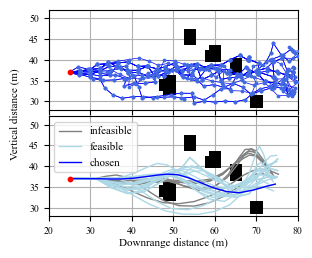

In [38]:
# set random seeds
np.random.seed(42)
random.seed(42)

## Part I perception
config = defaultConfig()
config.numObstacles = 40
drone = Drone.Drone(config, config)

thrustCommand = 4.3
fpaCommand = 0/180*np.pi
dynRef = drone.coherentCommand(thrustCommand,fpaCommand)
elivatorRef = drone.elevatorFromAlpha(dynRef[1]-dynRef[3])
stateRef = np.hstack(([0,50], dynRef))
action = (thrustCommand, elivatorRef, dynRef)
drone.reset(stateRef)

observation, grid, reward, terminated = drone.step(action)

fig, axs = plt.subplots(2, 1, figsize=(3.4, 2.4),sharex=True,layout="constrained");

# ax = axs[0]
# x = drone.ogOrigin[0]
# z = drone.ogOrigin[1]
# theta = drone.plant.state[3]
# beam = drone.lidar_range
# angle = drone.lidar_angle
# res = drone.lidar_res
# ax.plot([x,x+beam*np.cos(theta+angle/2)],[z,z+beam*np.sin(theta+angle/2)],'k--',zorder=3)
# ax.plot([x,x+beam*np.cos(theta-angle/2)],[z,z+beam*np.sin(theta-angle/2)],'k--',zorder=3)
# a = np.linspace(-angle/2,angle/2,int(res/3))
# xs = x+beam*np.cos(theta+a)
# zs = z+beam*np.sin(theta+a)
# ax.plot(xs,zs,'k.',markersize=1,zorder=3)
# ax.scatter(25, 37, color='red', s=10,zorder=3)


## PART II
ax = axs[0]
midpoint = drone.ogOrigin[1]
offset = 10
lookAhead = 54
orignX = drone.ogOrigin[0]
xstart = np.array([orignX, offset]) 
xgoal = [[orignX+lookAhead, offset], [orignX+lookAhead, offset/2],  [orignX+lookAhead, offset/4*2],  [orignX+lookAhead, offset*3/2]]
n = 10
r_rewire = 5
searchGrid = grid[midpoint-offset:midpoint+offset, 0:85].T.astype(int)
vectorsSave = []
limitIter = 100
li = 0
rrt = RRTAR()

while(len(vectorsSave) < 25 and li < limitIter):
    vectors = rrt.runRRT(xstart[0], xstart[1], 150, 2.5, 5, searchGrid, xgoal)
    li = li+1
    for i in range(1, len(vectors)):
        if (len(vectorsSave) < 25):
            vectorsSave.append(vectors[i])
print(len(vectorsSave))
#tree_plot_2d_vectors(vectors[0], grid[midpoint-offset:midpoint+offset, 0:85].T.astype(int))
for i in range(0, len(vectorsSave)):
    vectors = vectorsSave[i]
    for i in range(len(vectors)):
        x = vectors[i][0]
        y = vectors[i][1]+27

        if i > 0:
            target_x = vectors[i-1][0]
            target_y = vectors[i-1][1]+27

            ax.plot([x, target_x], [y, target_y], 'b-', linewidth=0.5,zorder=3)
        ax.scatter(x, y, color='royalblue', s=3,zorder=4)
ax.scatter(25, 37, color='red', s=10, zorder=7)


## Part III
ax = axs[1]
thrustCommandVal = 4.3
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))

iterations = 2000
iter = 0
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
xCommandfin = np.zeros(iterations)
yCommandfin = np.zeros(iterations)
thrustCommandFin = np.zeros(iterations)
elivCommandFin= np.zeros(iterations)

refCommand = np.zeros((iterations, 4))
timeMulti = 25
xstart = np.concatenate(([0.,0.], np.array(drone.stateEstimate) - np.array(refStates) ))
xgoal = np.concatenate(([0.,50 - drone.plant.state[1]], [0.,0.,0.,0.]))
tEnd = 450

minCost = 10000000
ax.scatter(25, 37, color='red', s=10, zorder=7)

first_infeas = True
first_feas = True

for vi in range(len(vectorsSave)):
    Acts, Bcts = drone.calculateCTSABMatrix(refStates, controlRef)
    Aopt = np.eye(Acts.shape[0]+2)
    #A = Aopt + env.calculateANumerical(stateRefFull, controlRef, env.rhoNom, step=10**-5)*env.dt
    Aopt[0, 2] = drone.dt*timeMulti
    Aopt[1, 5] = refStates[0]*drone.dt*timeMulti
    Aopt[2:,2:] = Aopt[2:,2:]+Acts*drone.dt*timeMulti
    Bopt = np.zeros([6,2])
    Bopt[2:,0:1] = Bcts*drone.dt*timeMulti
    alphaEst = refStates[1] - refStates[3]
    Bopt[2, 1] = 1/drone.m*np.cos(alphaEst)*drone.dt*timeMulti
    Bopt[5, 1] = 1/drone.m*np.sin(alphaEst)/refStates[0]*drone.dt*timeMulti

    path_pts = np.zeros((len(vectorsSave[vi]) - 1, 2, 2))
    for i in range(len(vectorsSave[vi]) - 1):
        path_pts[i] = np.array([[vectorsSave[vi][i][1], vectorsSave[vi][i][0]],
                        [vectorsSave[vi][i+1][1], vectorsSave[vi][i+1][0]]])
    referencePoints, referenceVels = ConvexMotionPlanning.calculateReferencePoints(math.floor(tEnd/timeMulti)+1, path_pts)
    referencePointsDyn, referenceVelsDyn = ConvexMotionPlanning.calculateReferencePoints(math.floor(tEnd/timeMulti)+1, path_pts)
    for i in range(len(referencePointsDyn)):
        referencePointsDyn[i][0] = referencePointsDyn[i][0]-refStates[0]*np.sin(refStates[3])*i*drone.dt*timeMulti-offset
        referencePointsDyn[i][1] = referencePointsDyn[i][1]-refStates[0]*np.cos(refStates[3])*i*drone.dt*timeMulti-orignX

    xsol, usol, cost, infeasbility = ConvexMotionPlanning.localTrajOpt(Aopt, Bopt, math.floor(tEnd/timeMulti), grid[midpoint-offset:, 0:80], referencePoints, referencePointsDyn, xstart, xgoal)
    if (infeasbility < 0.01):
        for i in range(np.min((tEnd-timeMulti-1, iterations-iter))):
            iDrop = math.floor(i/timeMulti)
            iNext = iDrop+1
            ifrac1 = (timeMulti - i%timeMulti)/timeMulti
            ifrac2 = (i%timeMulti)/timeMulti

            thrustCommand[iter+i] = ifrac1*usol[iDrop][1] + ifrac2*usol[iNext][1]  + thrustCommandVal 
            elivCommand[iter + i] = ifrac1*usol[iDrop][0] + ifrac2*usol[iNext][0] + elivCommandRef
            xCommand[iter+i] = ifrac1*xsol[iDrop][0] + ifrac2*xsol[iNext][0] +refStates[0]*np.cos(0)*i*drone.dt+drone.plant.state[0]
            yCommand[iter+i] = ifrac1*xsol[iDrop][1] + ifrac2*xsol[iNext][1] + refStates[0]*np.sin(0)*i*drone.dt+drone.plant.state[1]
            refCommand[iter+i, :] = ifrac1*xsol[iDrop][2:6].T + ifrac2*xsol[iNext][2:6].T + np.array(refStates)
        plt_feas, = ax.plot(xCommand[0:tEnd-timeMulti-1]+25, yCommand[0:tEnd-timeMulti-1]-13, color = 'lightblue', zorder=5)
        
        if(cost < minCost):
            minCost = cost
            thrustCommandFin = thrustCommand+0
            elivCommandFin = elivCommand+0
            xCommandfin = xCommand+0
            yCommandfin = yCommand+0
    else:
        for i in range(np.min((tEnd-timeMulti-1, iterations-iter))):
            iDrop = math.floor(i/timeMulti)
            iNext = iDrop+1
            ifrac1 = (timeMulti - i%timeMulti)/timeMulti
            ifrac2 = (i%timeMulti)/timeMulti

            thrustCommand[iter+i] = ifrac1*usol[iDrop][1] + ifrac2*usol[iNext][1]  + thrustCommandVal 
            elivCommand[iter + i] = ifrac1*usol[iDrop][0] + ifrac2*usol[iNext][0] + elivCommandRef
            xCommand[iter+i] = ifrac1*xsol[iDrop][0] + ifrac2*xsol[iNext][0] +refStates[0]*np.cos(0)*i*drone.dt+drone.plant.state[0]
            yCommand[iter+i] = ifrac1*xsol[iDrop][1] + ifrac2*xsol[iNext][1] + refStates[0]*np.sin(0)*i*drone.dt+drone.plant.state[1]
            refCommand[iter+i, :] = ifrac1*xsol[iDrop][2:6].T + ifrac2*xsol[iNext][2:6].T + np.array(refStates)
        plt_infeas, = ax.plot(xCommand[0:tEnd-timeMulti-1]+25, yCommand[0:tEnd-timeMulti-1]-13, color = 'grey', zorder=4)
        
plt_chosen, = ax.plot(xCommandfin[0:tEnd-timeMulti-1]+25, yCommandfin[0:tEnd-timeMulti-1]-13, color = 'blue', zorder=6)
ax.legend([plt_infeas, plt_feas, plt_chosen], ["infeasible", "feasible", "chosen"], loc="upper left")

# SET AXIS LIMITS, PLOT OBSTACLES, AND INSERT LABELS
for ax in axs:
    ax.imshow(grid, interpolation=None, cmap=cmap, norm=norm, zorder=2)
    ax.invert_yaxis()
    ax.set_xlim(22,78)
    ax.set_ylim(28,52)
    ax.set_xticks(np.arange(20,81,10))
    ax.grid(True,zorder=0)

fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)
fig.supxlabel('Downrange distance (m)')
fig.supylabel('Vertical distance (m)',y=0.56,x=0.02)

plt.savefig('fig6_multi-trajectory.pdf')
plt.show()

---
# Figure 7

Sample run of MPP with 25 obstacles

In [13]:
# set random seeds
np.random.seed(43)
random.seed(43)

# Drone instantiation
config = defaultConfig()
config.numObstacles = 20
drone = Drone.Drone(config, config)

# Parameters
thrustCommandVal = 4.3
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))
iterations = 2500
iter = 0
pathDist = 100
stateRef = np.hstack(([0,50], refStates))
drone.reset(stateRef)

# Data
traj = np.zeros((7,iterations))
elvActual = np.zeros(iterations)
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
refCommand = np.zeros((iterations, 4))
refCommand[0] = refStates

# Main loop
for iter in range(0, iterations):
    action = [thrustCommand[iter], elivCommand[iter], refCommand[iter, :]] 
    observation, grid, reward, terminated = drone.step(action)
    traj[:,iter] = np.hstack((drone.plant.state,drone.plant.time))
    elvActual[iter] = drone.delta_e_actual
    if(iter%pathDist == 0):
        thrustCommand, elivCommand, xCommand, yCommand, refCommand = ConvexMotionPlanning.TrajGenMPP(drone, grid, thrustCommand, elivCommand, xCommand, yCommand, refStates, refCommand, thrustCommandVal,elivCommandRef, iterations, iter)
    if(terminated):
        break

vRef = refCommand[:,0]
thetaRef = refCommand[:,1]
gammaRef = refCommand[:,3]
x = traj[0,:]
y = traj[1,:]
v = traj[2,:]
theta = traj[3,:]
thetaDot = traj[4,:]
gamma = traj[5,:]
time = traj[6,:]
;

''

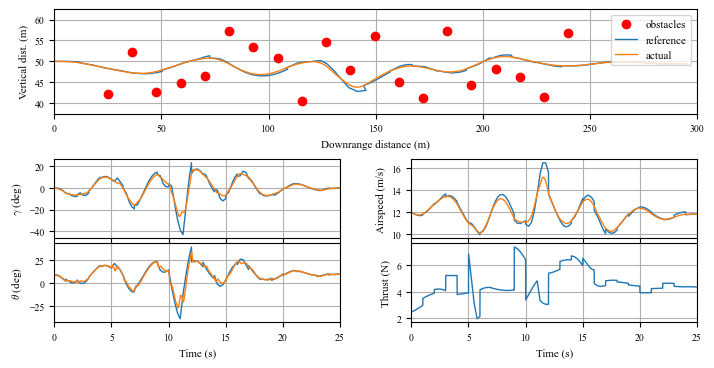

In [30]:
# Create a 3x2 grid for subplots
fig = plt.figure(figsize=(7, 3.5))
gs = GridSpec(3, 2, height_ratios=[3,3,3], width_ratios=[1, 1])

# Big subplot in the top center
big_subplot = fig.add_subplot(gs[0, :])
inner = GridSpec(3, 2, height_ratios=[11,6,6], width_ratios=[1, 1],hspace=0.05, wspace=0.25)

# Subplots in the first column
small_subplot_2 = fig.add_subplot(inner[2, 0])
small_subplot_1 = fig.add_subplot(inner[1, 0])

# Subplots in the second column
small_subplot_4 = fig.add_subplot(inner[2, 1])
small_subplot_3 = fig.add_subplot(inner[1, 1])

big_subplot.scatter(drone.objects[0,:],drone.objects[1,:], color = "red",  label="obstacles",zorder=3 )
big_subplot.set_xlim((0, 300))
big_subplot.set_ylim((37.5, 62.5))
big_subplot.plot(xCommand, yCommand, label="reference")
big_subplot.plot(x, y,  label="actual")
big_subplot.set_ylabel("Vertical dist. (m)")
big_subplot.set_xlabel("Downrange distance (m)")
big_subplot.grid(True)
big_subplot.legend(loc="upper right")

small_subplot_1.plot(time,gammaRef*180/np.pi)
small_subplot_1.plot(time,gamma*180/np.pi)
small_subplot_1.set_ylabel(r"$\gamma$ (deg)")
small_subplot_1.set_xticklabels([])
small_subplot_1.grid(True)
small_subplot_1.set_xlim((0,25))

small_subplot_2.plot(time,thetaRef*180/np.pi)
small_subplot_2.plot(time,theta*180/np.pi)
small_subplot_2.set_ylabel(r"$\theta$ (deg)")
small_subplot_2.set_xlabel("Time (s)")
small_subplot_2.grid(True)
small_subplot_2.set_xlim((0,25))

small_subplot_3.plot(time,vRef)
small_subplot_3.plot(time,v)
small_subplot_3.set_ylabel("Airspeed (m/s)")
small_subplot_3.grid(True)
small_subplot_3.set_xticklabels([])
small_subplot_3.set_xlim((0,25))

small_subplot_4.plot(time,thrustCommand)
small_subplot_4.set_ylabel("Thrust (N)")
small_subplot_4.set_xlabel("Time (s)")
small_subplot_4.grid(True)
small_subplot_4.set_xlim((0,25))

# Show the plot
# adjust spacing manually because tight_layout and layout=constrained don't appear to work with gridspec...
fig.subplots_adjust(left=0.07, right=0.988, bottom=0.1, top=0.995, wspace=0, hspace=0)
plt.savefig('fig7_sample_MPP_run.pdf')
plt.show()

# Figure 8

MPP Monte Carlo simulation.
Full code takes about 12 hours to run.
Plot is hard-coded with final results (see second cell)

In [39]:
%%time

# set random seeds
np.random.seed(42)
random.seed(42)

# test run (took about 50 minutes)
trials = 3
pathSamples_list = [5,0]
obstacles_list = [5,10]

# # FULL RUN (takes a long time!)
# trials = 100
# pathSamples_list = [25, 5, 1, 0]  # RRT* is quite slow!
# obstacles_list = [0, 5, 10, 15, 20]


# initialize successes count
successes = np.zeros( (len(pathSamples_list), len(obstacles_list)) )

for (pix,pathSamples) in enumerate(pathSamples_list):
    print(f"PATH {pix+1}, pathSamples = {pathSamples}")

    for (oix,obstacles) in enumerate(obstacles_list):
        print(f"  Obstacles = {obstacles}")

        for i in range(trials):
            print(f"    Trial {i+1} of {trials}...", end=" ")
            
            # Drone instantiation
            config = defaultConfig()
            config.numObstacles = obstacles
            drone = Drone.Drone(config, config)
    
            # Parameters
            thrustCommandVal = 4.3
            refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
            controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))
            iterations = 2000
            iter = 0
            pathDist = 100
            stateRef = np.hstack(([0,50], refStates))
            drone.reset(stateRef)
    
            # Data
            traj = np.zeros((7,iterations))
            elvActual = np.zeros(iterations)
            thrustCommand = np.zeros(iterations)+thrustCommandVal
            stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
            elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
            elivCommand = np.zeros(iterations) + elivCommandRef
            xCommand = np.zeros(iterations)
            yCommand = np.zeros(iterations)
            refCommand = np.zeros((iterations, 4))
            refCommand[0] = refStates
    
            # Main loop
            iter = 0
            terminated = False
            while iter < iterations and (not terminated):
                action = [thrustCommand[iter], elivCommand[iter], refCommand[iter, :]] 
                observation, grid, reward, terminated = drone.step(action)
                traj[:,iter] = np.hstack((drone.plant.state,drone.plant.time))
                elvActual[iter] = drone.delta_e_actual
                if(iter%pathDist == 0):
                    try:
                        if pathSamples == 0: # do RRT*
                            thrustCommand, elivCommand, xCommand, yCommand, refCommand = ConvexMotionPlanning.TrajGenRRT(drone, grid, thrustCommand, elivCommand, xCommand, yCommand, refStates, refCommand, thrustCommandVal,elivCommandRef, iterations, iter)
                        else: # do MPP
                            thrustCommand, elivCommand, xCommand, yCommand, refCommand = ConvexMotionPlanning.TrajGenMPP(drone, grid, thrustCommand, elivCommand, xCommand, yCommand, refStates, refCommand, thrustCommandVal,elivCommandRef, iterations, iter, pathSamples=pathSamples)
                    except:
                        terminated = True
                iter += 1
            if (not terminated):
                print(" SUCCESS")
                successes[pix,oix] += 1
            else:
                print(" FAILURE")



PATH 1, pathSamples = 5
  Obstacles = 5
    Trial 1 of 3...  SUCCESS
    Trial 2 of 3...  SUCCESS
    Trial 3 of 3...  SUCCESS
  Obstacles = 10
    Trial 1 of 3...  SUCCESS
    Trial 2 of 3...  SUCCESS
    Trial 3 of 3...  SUCCESS
PATH 2, pathSamples = 0
  Obstacles = 5
    Trial 1 of 3... 

C:\Users\laure\anaconda3\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
C:\Users\laure\anaconda3\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


 SUCCESS
    Trial 2 of 3... [False] [False] [False] [False] [False] [False] [False] [False] [ True] [False] [False]
 FAILURE
    Trial 3 of 3...  SUCCESS
  Obstacles = 10
    Trial 1 of 3...  SUCCESS
    Trial 2 of 3...  SUCCESS
    Trial 3 of 3...  SUCCESS
CPU times: total: 49min 52s
Wall time: 52min 49s


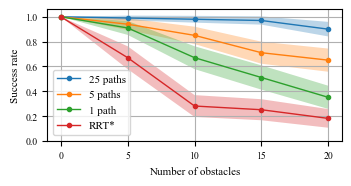

In [41]:
# RESULT FROM FULL RUN:
trials = 100
pathSamples_list = [25, 5, 1, 0]
obstacles_list = [0, 5, 10, 15, 20]
successes = np.array([[100, 99, 98, 97, 90],[100, 94, 85, 71, 65],[100, 91, 67, 51, 35],[100, 67, 28, 25, 18]])


# compute confidence intervals on empirical probabilities
probs = successes / trials
zscore = 1.96  # confidence level = 95%
CIs = np.array([[ zscore * np.sqrt( p*(1-p)/trials ) for p in thispath] for thispath in probs] )

# make plots
fig, ax = plt.subplots(1,1,figsize=(3.4,1.75),layout="constrained")

# plot the means
for (pix,pathSamples) in enumerate(pathSamples_list):
    if pathSamples == 0:
        labelstr = f"RRT*"
    elif pathSamples == 1:
        labelstr = f"1 path"
    else:
        labelstr = f"{pathSamples} paths"
    ax.plot(obstacles_list, probs[pix], marker='o', markersize=3, label = labelstr)

# plot the confidence intervals
for (pix,pathSamples) in enumerate(pathSamples_list):
    ax.fill_between(obstacles_list, probs[pix] - CIs[pix], probs[pix] + CIs[pix], alpha=0.3)

ax.set_ylabel(r"Success rate")
ax.set_xlabel(r"Number of obstacles")
ax.set_xticks(obstacles_list)
ax.grid(True)
ax.legend(loc="lower left")
ax.set_ylim((0, 1.06))

plt.savefig('fig8_MPP_monte_carlo.pdf')
plt.show()